In [2]:
# pragma pylint: disable=line-too-long

In [3]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

bandpass_arrays = []

data_path = "/home/jovyan/ska-ost-low-aavs3/notebooks/SFT/StationSFT.2.AllChannels/data/channel_burst_{t}_20240119_13284_0.hdf5"
data_path = "/home/jovyan/daq-data/eb-local-20240119-788407690/ska-low-mccs/scan-local-352619098834311/product/aavs3/acquisition-2024-01-19/channel_burst_%d_20240119_12601_0.hdf5"
data_path = "/home/jovyan/daq-data/eb-local-20240119-764620937/ska-low-mccs/scan-local-606711768143109/product/aavs3/acquisition-2024-01-19/channel_burst_%d_20240119_12447_0.hdf5"
data_path = "/home/jovyan/daq-data/eb-local-20240119-733709859/ska-low-mccs/scan-local-718993662180355/product/aavs3/acquisition-2024-01-19/channel_burst_%d_20240119_13284_0.hdf5"
for t in range(16):
    with h5py.File(data_path % t) as f:
        data = f["chan_"]["data"]
        complex_data = data[:][:]["real"] + data[:][:]["imag"] * 1j
        reshaped_data = complex_data.reshape(1024, 512, 16, 2).transpose(0, 2, 3, 1)
        abs_data = np.abs(reshaped_data)

        np.seterr(divide="ignore")
        abs_data = 20 * np.log10(abs_data)
        np.seterr(divide="warn")
        abs_data[np.isneginf(abs_data)] = 0

        abs_data = np.mean(abs_data, axis=0)
        bandpass_arrays.append(abs_data)

bandpass_data = np.concatenate(bandpass_arrays)

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/home/jovyan/daq-data/eb-local-20240119-733709859/ska-low-mccs/scan-local-718993662180355/product/aavs3/acquisition-2024-01-19/channel_burst_0_20240119_13284_0.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [6]:
bandpass_arrays = []

data_path = "/home/jovyan/shared/test_executions/2024-06-20_204111_s8-6/01.SingleChannel/daq-data/channel_integ_%d_20240620_45697_0.hdf5"
for t in range(16):
    with h5py.File(data_path % t) as f:
        data = f["chan_"]["data"]
        reshaped_data = (
            data[:][:].reshape(2048, 512, 16, 2).transpose(0, 2, 3, 1)[:, :, :, 1:]
        )
        abs_data = np.abs(reshaped_data)

        np.seterr(divide="ignore")
        abs_data = 20 * np.log10(abs_data)
        np.seterr(divide="warn")
        abs_data[np.isneginf(abs_data)] = np.nan

        bandpass_arrays.append(abs_data)

bandpass_data = np.concatenate(bandpass_arrays, axis=1)
print(bandpass_data.shape)

(2048, 256, 2, 511)


In [7]:
all_bps = bandpass_data.reshape(-1, 511)
all_bps
active_bps = all_bps[np.nanmax(all_bps, axis=1) > 35.0]

/tmp/ipykernel_539/21118757.py:3: RuntimeWarning: All-NaN slice encountered
  active_bps = all_bps[np.nanmax(all_bps, axis=1) > 35.0]


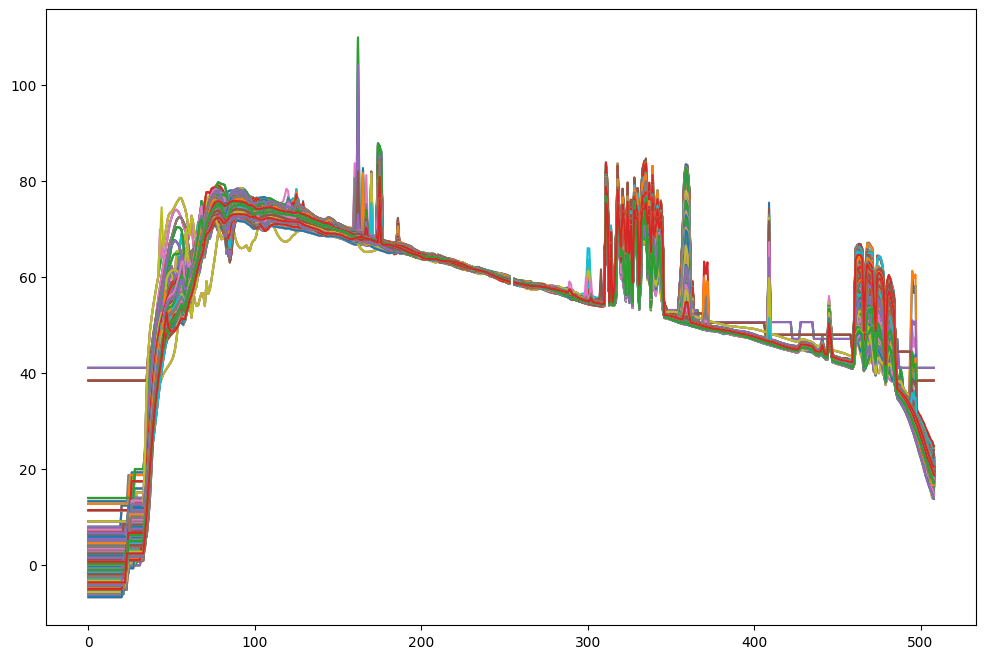

In [8]:
%matplotlib inline

bandpasses = xr.DataArray(bandpass_data, dims=["sample", "ant", "pol", "cc"])


def equalise(bps, slc=slice(None, None, None)):
    all_off = bps.reshape(-1, 511)
    all_off_mean = np.median(all_off[:, slc], axis=0)
    mean_diff = np.nanmean(all_off[:, slc] - all_off_mean, axis=1)
    return all_off - np.tile(mean_diff, (511, 1)).transpose()


equalised_off = equalise(bandpass_data[0], slice(200, 300))

plt.figure(figsize=(12, 8))
for x in equalised_off:
    plt.plot(x)
plt.show()

plt.figure(figsize=(12, 8))
for x in equalise(active_bps, slice(200, 300)):
    plt.plot(x)
plt.show()

In [9]:
print(np.array([[1, 2, 3, 4, 5, 6, 7]]).transpose())
np.tile(np.array([1, 2, 3, 4, 5, 6, 7]).transpose(), (3, 1))

[[1]
 [2]
 [3]
 [4]
 [5]
 [6]
 [7]]


array([[1, 2, 3, 4, 5, 6, 7],
       [1, 2, 3, 4, 5, 6, 7],
       [1, 2, 3, 4, 5, 6, 7]])

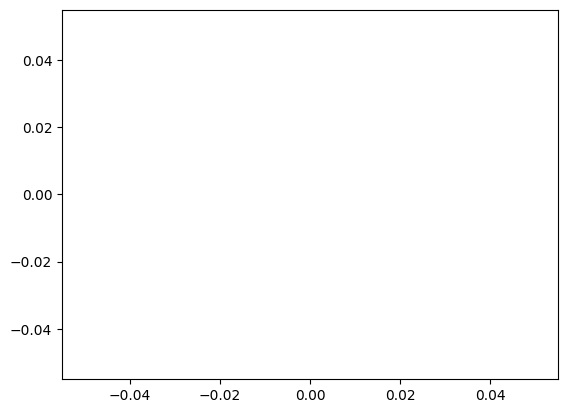

In [10]:
plt.plot(abs_data[1999][0][0][1:])

2024-06-21 02:15:46,178 - INFO - Filepath specified, clearing all set plotting modes
2024-06-21 02:15:46,179 - INFO - Plotting channelised antenna data


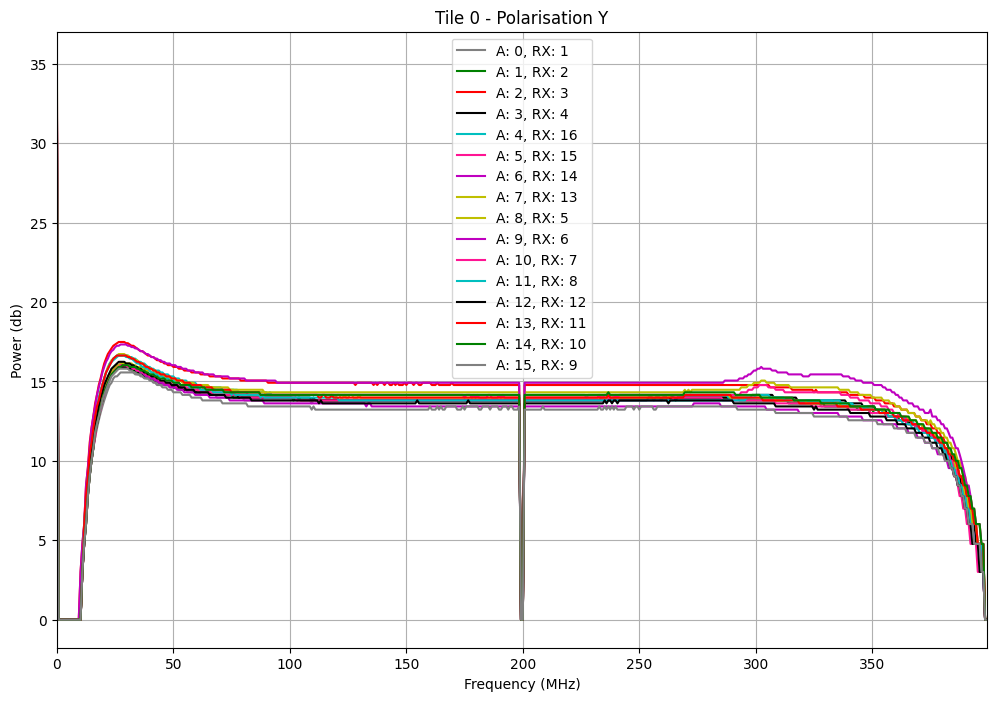

In [11]:
data_path = "/home/jovyan/shared/test_executions/2024-06-20_204111_s8-6/01.SingleChannel/daq-data/channel_integ_0_20240620_45697_0.hdf5"
%run -m pydaq.daq_plotter -- -f {data_path} --plot_type spectrum -s 1 --log

[[ 17]
 [ 19]
 [ 21]
 [291]]


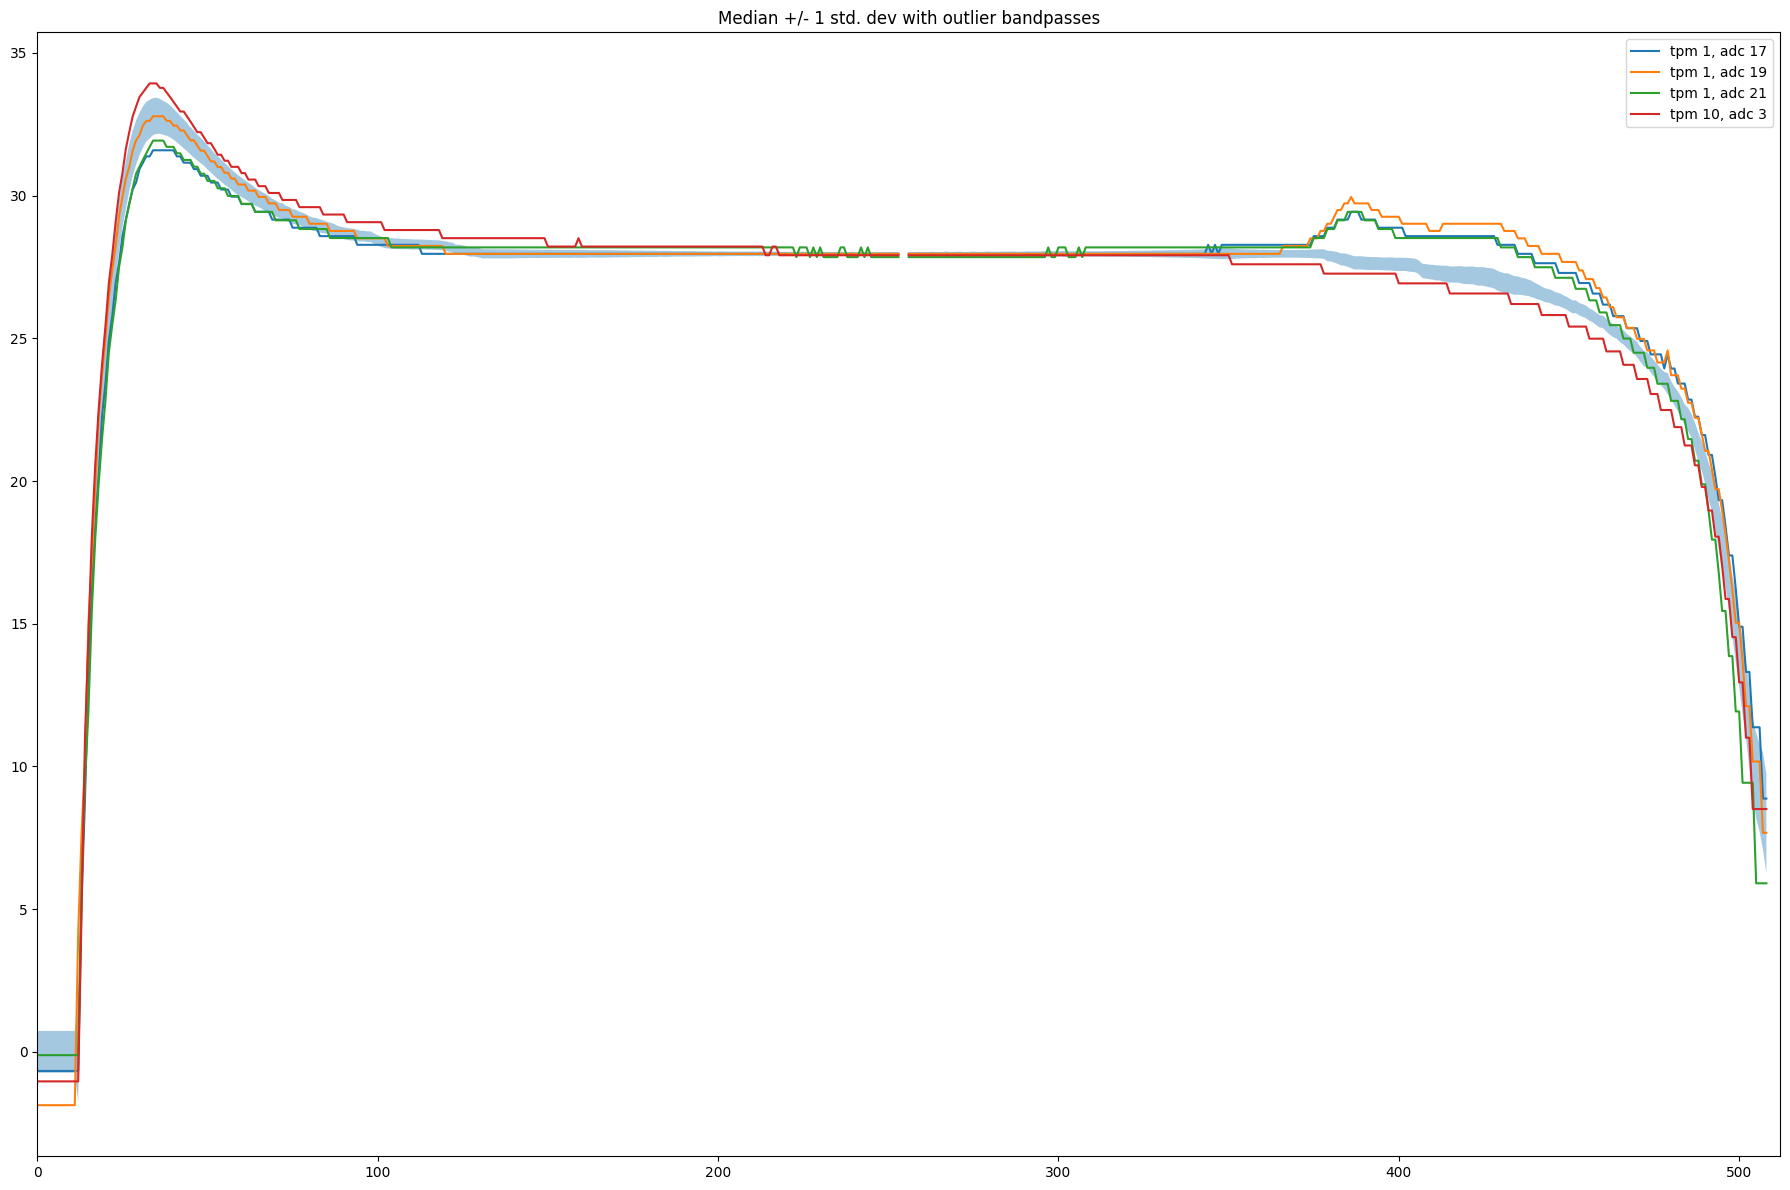

In [12]:
bandpasses = equalise(bandpass_data[0], slice(200, 300))
maxes = np.nanmax(bandpasses, axis=1) > 5
pol_med = np.concatenate(
    [[np.median(bps[mask], axis=0)] for bps, mask in zip([bandpasses], [maxes])]
)
pol_std = np.concatenate(
    [[np.std(bps[mask], axis=0)] for bps, mask in zip([bandpasses], [maxes])]
)

# with np.errstate(divide="ignore"):
#     fig, axs = plt.subplots(
#         1, 2, sharex=True, sharey=True, tight_layout=True, figsize=(18, 6)
#     )
#     for ax, bps, med, std in zip(axs, [bandpasses], pol_med, pol_std):
#         ax.set_xlim(0, 512)
#         for bp in bps:
#             ax.plot(((bp - med) / std))
#     plt.show()

fig, axs = plt.subplots(
    1, 1, sharex=True, sharey=True, tight_layout=True, figsize=(18, 12)
)
for ax, bps, med, std in zip([axs], [bandpasses], pol_med, pol_std):
    ax.set_xlim(0, 512)
    ax.fill_between(np.arange(511), med - std, med + std, alpha=0.4)
    # ax.plot(med)
    outliers = np.argwhere(np.sqrt(np.nanmean(((bps - med) / std) ** 2, axis=1)) > 2.0)
    print(outliers)
    for [bp] in outliers:
        idx, adc = divmod(bp, 32)
        idx, tpm = divmod(idx, 16)
        ax.plot(bps[bp], label=f"tpm {tpm + 1}, adc {adc}")
plt.legend()
plt.title("Median +/- 1 std. dev with outlier bandpasses")
plt.show()

# fig, axs = plt.subplots(
#     1, 2, sharex=True, sharey=True, tight_layout=True, figsize=(18, 6)
# )
# for ax, bps, med, std in zip(axs, [bandpasses], pol_med, pol_std):
#     ax.set_xlim(0, 512)
#     ax.fill_between(np.arange(512), med - std, med + std, alpha=0.4)
#     for bp in bps[np.sqrt(np.mean((bps - med) ** 2, axis=1)) <= 1.0]:
#         ax.plot(bp)
# plt.show()

In [14]:
bandpasses = bandpass_data.transpose(1, 0, 2)
maxes = np.max(bandpasses[:, :, 1:], axis=2) > 5
pol_med = np.concatenate(
    [[np.median(bps[mask], axis=0)] for bps, mask in zip(bandpasses, maxes)]
)
pol_std = np.concatenate(
    [[np.std(bps[mask], axis=0)] for bps, mask in zip(bandpasses, maxes)]
)

with np.errstate(divide="ignore"):
    fig, axs = plt.subplots(
        1, 2, sharex=True, sharey=True, tight_layout=True, figsize=(18, 6)
    )
    for ax, bps, med, std in zip(axs, bandpasses, pol_med, pol_std):
        ax.set_xlim(0, 512)
        for bp in bps:
            ax.plot(((bp - med) / std))
    plt.show()

fig, axs = plt.subplots(
    1, 2, sharex=True, sharey=True, tight_layout=True, figsize=(18, 6)
)
for ax, bps, med, std in zip(axs, bandpasses, pol_med, pol_std):
    ax.set_xlim(0, 512)
    # ax.fill_between(np.arange(512), med - std, med + std, alpha=0.4)
    ax.plot(std)
    # for bp in bps[np.sqrt(np.mean(((bps - med)/std)**2, axis=1)) > 5.0]:
    #     ax.plot(bp)
plt.show()

fig, axs = plt.subplots(
    1, 2, sharex=True, sharey=True, tight_layout=True, figsize=(18, 6)
)
for ax, bps, med, std in zip(axs, bandpasses, pol_med, pol_std):
    ax.set_xlim(0, 512)
    ax.fill_between(np.arange(512), med - std, med + std, alpha=0.4)
    for bp in bps[np.sqrt(np.mean((bps - med) ** 2, axis=1)) <= 1.0]:
        ax.plot(bp)
plt.show()

ValueError: axes don't match array

2024-04-08 02:12:02,775 - INFO - Filepath specified, clearing all set plotting modes
2024-04-08 02:12:02,776 - INFO - Plotting channelised antenna data


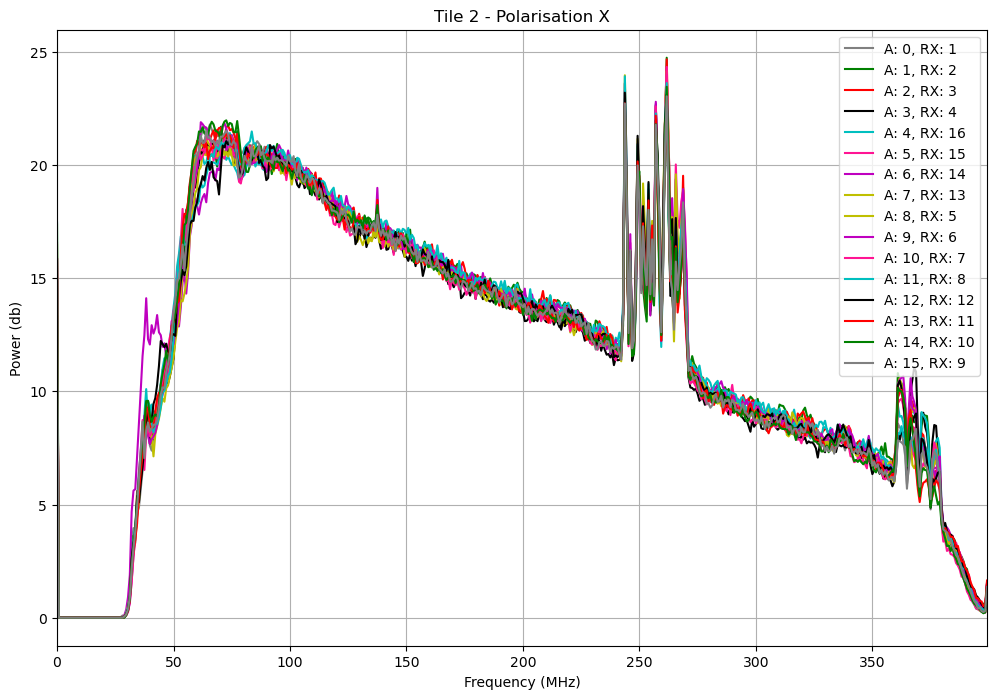

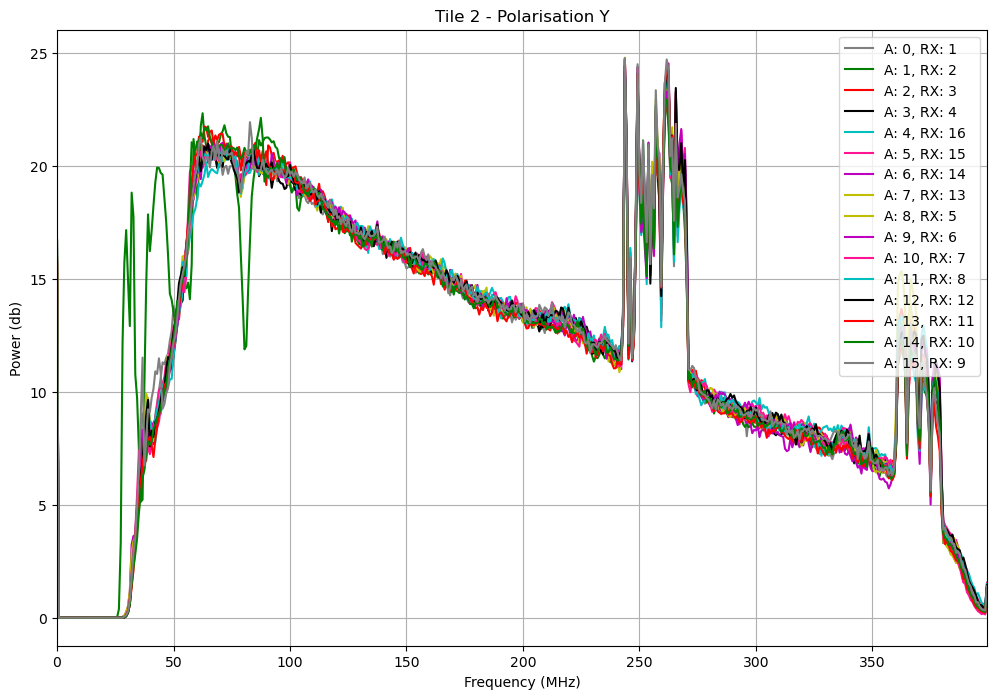

In [105]:
%run -m pydaq.daq_plotter -- --log --plot_type spectrum -f ~/ska-ost-low-aavs3/notebooks/SFT/StationSFT.2.AllChannels/data/channel_burst_2_20240119_13284_0.hdf5